## CIFAR-100 Classification

In this dataset, we'll primarily be testing EfficientNetB0 to see if base classification is efficient.

In [1]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import cv2
import albumentations as albu
%matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D 
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.transform import resize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import efficientnet.keras as efn

In [12]:
# File downloaded to local folder
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict

In [55]:
train = unpickle('train')
test = unpickle('test')
meta = unpickle('meta')

for item in train:
    print(item, type(train[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


### Analysis Part I
We'll try to see what sort of data we'll be playing with here.
We'll also see if we can see a sample of each category.

In [56]:
train_vol = pd.DataFrame(train['coarse_labels'], columns = ['train_volume'])
train_vol = pd.DataFrame(train_vol['train_volume'].value_counts())
test_vol = pd.DataFrame(test['coarse_labels'], columns = ['test_volume'])
test_vol = pd.DataFrame(test_vol['test_volume'].value_counts())
df = pd.DataFrame(meta['coarse_label_names'], columns = ['class'])
frames = [df, train_vol, test_vol]
df = pd.concat(frames, axis = 1)
df

,class,train_volume,test_volume
0,aquatic_mammals,2500,500
1,fish,2500,500
2,flowers,2500,500
3,food_containers,2500,500
4,fruit_and_vegetables,2500,500
5,household_electrical_devices,2500,500
6,household_furniture,2500,500
7,insects,2500,500
8,large_carnivores,2500,500
9,large_man-made_outdoor_things,2500,500


In [57]:
category = pd.DataFrame(meta['coarse_label_names'], columns = ['SuperClass'])
subCategory = pd.DataFrame(meta['fine_label_names'], columns = ['SubClass'])

In [58]:
X_train = train['data']
X_train

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

In [59]:
X_train = X_train.reshape(len(X_train), 3, 32, 32).transpose(0, 2, 3, 1)

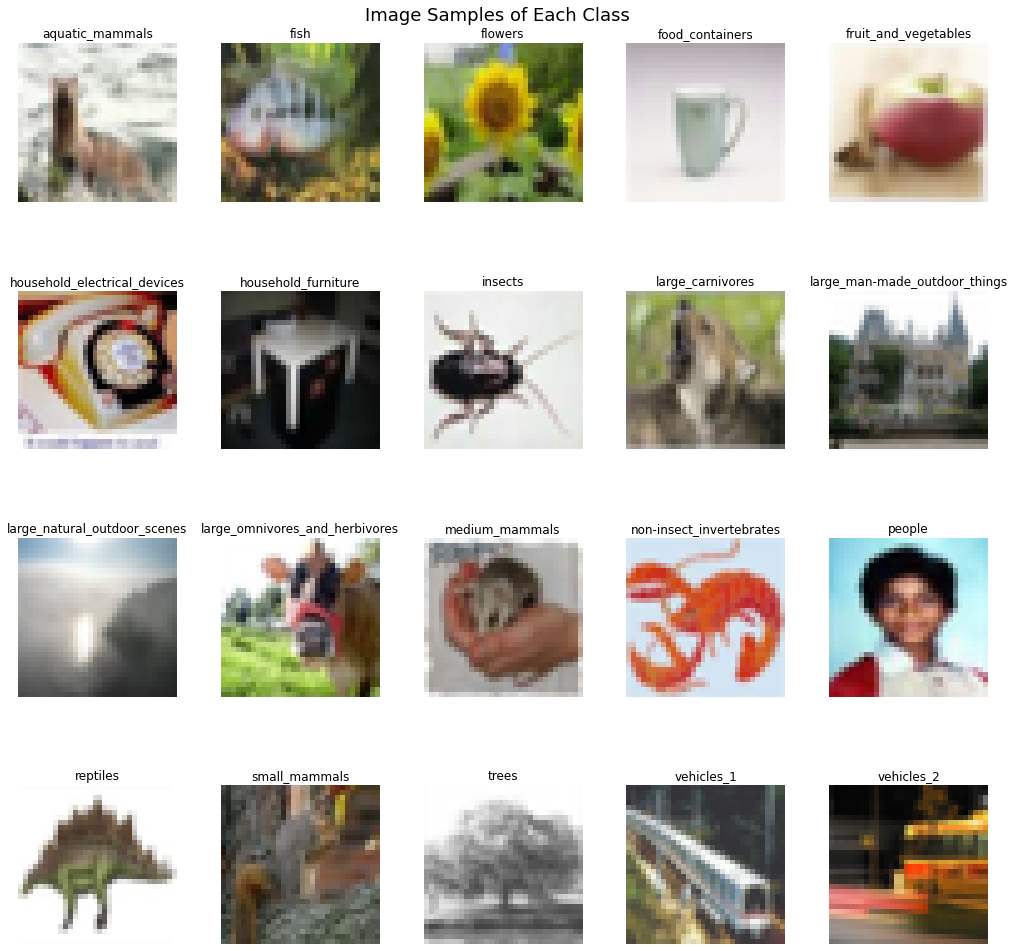

In [60]:
rcParams['figure.figsize'] = 14, 14
row = 4
col = 5

class_list = []
for n in range(0, 20):
    class_list.append(list(train['coarse_labels']).index(n))

fig, axes = plt.subplots(row, col)
plt.suptitle('Image Samples of Each Class', fontsize = 18)
plt.tight_layout(pad = 0.2, w_pad = 1.0, h_pad = 0.5)
fig.set_facecolor('white')

for i in range(0, row):
    for j in range(0, col):
        k = (i * col) + j
        axes[i, j].imshow(X_train[class_list[k]])
        axes[i, j].set_title(category.iloc[train['coarse_labels'][class_list[k]]][0])
        axes[i, j].axis('off')

plt.savefig('class_image_sample.png', facecolor = fig.get_facecolor())

### Modeling
Next, we'll try to create a pipeline that breaks down the images within EfficientNetB0 for easier reading.

This will be essentially involve us breaking the image down into 3 channels,
then resizing the image.

In [61]:
X_test = test['data']
X_test = X_test.reshape(len(X_test), 3, 32, 32).transpose(0, 2, 3, 1)
X_test.shape

(10000, 32, 32, 3)

In [62]:
y_train = train['fine_labels']
y_test = test['fine_labels']

n_classes = 100
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

In [63]:
sss = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 123)

for train_index, val_index in sss.split(X_train, y_train):
    X_train_data, X_val_data = X_train[train_index], X_train[val_index]
    y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Training samples: ", X_train_data.shape[0])
print("Validation samples: ", X_val_data.shape[0])

Training samples:  40000
Validation samples:  10000


In [64]:
img_shape = 224
channels = 3

input_shape = (img_shape, img_shape, channels)

epochs = 15
batch_size = 8

In [65]:
def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

In [66]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, labels = None, mode = 'fit', batch_size = batch_size, 
                 dim = (img_shape, img_shape), channels = channels, n_classes = n_classes, 
                 shuffle = True, augment = False):
        
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        X = np.empty((self.batch_size, *self.dim, self.channels))
        
        for i, ID in enumerate(batch_indexes):
            img = self.images[ID]  
            img = img.astype(np.float32)/255.
            img = resize_img(img, self.dim)
            X[i] = img
            
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("Mode needs to be either 'fit' or 'predict'.")
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                   albu.VerticalFlip(p = 0.5),
                                   albu.GridDistortion(p = 0.2),
                                   albu.ElasticTransform(p = 0.2)])
        return composition(image = img)['image']
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch    

In [67]:
train_data_generator = DataGenerator(X_train_data, y_train_data, augment = True)
valid_data_generator = DataGenerator(X_val_data, y_val_data, augment = False)

In [68]:
effb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, 
                           input_shape = input_shape, classes = n_classes)

model = Sequential()
model.add(effb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [69]:
optimizer = Adam(lr = 0.0001)
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10, 
                           restore_best_weights = True)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5, factor = 0.5, min_lr = 1e-6, 
                          verbose = 1)

In [70]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
model_history = model.fit_generator(train_data_generator, validation_data = valid_data_generator, 
                                    callbacks = [early_stop, rlrop], verbose = 1, epochs = epochs)

model.save_weights("cifareffnetb0_weights.h5")

C:\Users\rngaw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
5000/5000 [==============================] - 9339s 2s/step - loss: 3.4637 - accuracy: 0.2013 - val_loss: 1.1221 - val_accuracy: 0.6701
Epoch 2/15
5000/5000 [==============================] - 9466s 2s/step - loss: 1.7447 - accuracy: 0.5219 - val_loss: 0.9223 - val_accuracy: 0.7300
Epoch 3/15
5000/5000 [==============================] - 8952s 2s/step - loss: 1.3862 - accuracy: 0.6140 - val_loss: 0.8458 - val_accuracy: 0.7557
Epoch 4/15
5000/5000 [==============================] - 8851s 2s/step - loss: 1.2032 - accuracy: 0.6561 - val_loss: 0.8158 - val_accuracy: 0.7758
Epoch 5/15
5000/5000 [==============================] - 8796s 2s/step - loss: 1.0825 - accuracy: 0.6901 - val_loss: 0.8067 - val_accuracy: 0.7830
Epoch 6/15
5000/5000 [==============================] - 8794s 2s/step - loss: 0.9651 - accuracy: 0.7218 - val_loss: 0.8090 - val_accuracy: 0.7878
Epoch 7/15
5000/5000 [==============================] - 8801s 2s/step - loss: 0.8965 - accuracy: 0.7415 - val_loss: 0.7835 -

In [32]:
model.save('cifar_effb0_model.h5')

### Analysis Part II

Now that we have our model has finished. We'll be looking into our loss and accuracy.

We'll also be seeing how well the classification has done in general.

In [2]:
plt.figure(figsize = (16, 8))

plt.suptitle('Loss and Accuracy', fontsize = 16)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label = 'Training Loss')
plt.plot(model_history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label = 'Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.show()

NameError: name 'plt' is not defined

In [34]:
valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_data_generator, verbose = 1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

C:\Users\rngaw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1250/1250 [==============================] - 394s 315ms/step - loss: 0.7832 - accuracy: 0.8138
Validation Accuracy:  81.38 %


In [35]:
y_pred = model.predict_generator(DataGenerator(X_test, mode ='predict', augment = False, 
                                               shuffle = False), verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)
test_accuracy = accuracy_score(np.argmax(y_test, axis = 1), y_pred)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

C:\Users\rngaw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1250/1250 [==============================] - 364s 290ms/step
Test Accuracy:  81.25 %


In [44]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)

[[96  0  0 ...  0  0  0]
 [ 0 92  0 ...  0  0  0]
 [ 0  0 70 ...  0  2  0]
 ...
 [ 0  0  0 ... 88  0  0]
 [ 0  0  3 ...  0 72  0]
 [ 0  0  0 ...  0  1 85]]


In [43]:
target = ["Category {}".format(i) for i in range(n_classes)]
print(classification_report(np.argmax(y_test, axis = 1), y_pred, target_names = target))

              precision    recall  f1-score   support

  Category 0       0.88      0.96      0.92       100
  Category 1       0.92      0.92      0.92       100
  Category 2       0.67      0.70      0.68       100
  Category 3       0.76      0.64      0.70       100
  Category 4       0.72      0.67      0.69       100
  Category 5       0.74      0.83      0.78       100
  Category 6       0.83      0.95      0.88       100
  Category 7       0.85      0.84      0.84       100
  Category 8       0.96      0.97      0.97       100
  Category 9       0.89      0.93      0.91       100
 Category 10       0.69      0.54      0.61       100
 Category 11       0.53      0.49      0.51       100
 Category 12       0.90      0.77      0.83       100
 Category 13       0.86      0.68      0.76       100
 Category 14       0.96      0.87      0.91       100
 Category 15       0.86      0.89      0.87       100
 Category 16       0.81      0.80      0.80       100
 Category 17       0.92    

# Conclusion

## Model Reasoning

For regularization, I used drop-out. This technique removes a random number of activators within the model. That is to say, at every iteration, a node is randomly selected and all the input and output connections are removed. I used a value of 0.5 (50%) for the hidden layers to avoid overfitting in my model. As there are around 4.2 million parameters in my model, drop-out gives the outputs that are participating to be randomply subsampled, lowering the chances of overfitting.

My reasoning for choosing drop-out was to introduce more randomness within the model. Another reason was to introduce sparse representation in my model, to accelerate learning and simplify the model (given my available resources).

EfficientNet-B0 was used as my architecture due to its effectiveness, computational power (given my computer's lack of CPU), and accuracy prediction when compared to other architectures such as DenseNet-201, ResNet-50, Inception-v2 etc.
This architecture scales uniformly, scales dimensions by a fixed amount simultaneously, helping to achieving better performance over earlier models, and this playthrough was a test to that.

EfficientNet in general has a cost efficient method for transfer learning. 
That is to say, with how EfficientNet scales the depth, width, and resolution of images, I can use the model here, for a new set of problems, if the need arises. For example, I could probably use this model on the ImageNet data, which contains more than 1.2 million images.
Furthermore in regards to effectiveness and accuracy, this architecture divides the original convolution of an activation into two stages, depthwise and pointwise, which further reducing the cost of calculation all at a minimum loss of accuracy.
Also, this architecture uses linear activation at each block in the last layer to prevent losses of info from ReLU.

B0 was used in particular because of the amount of parameters that would be used in the model, ultimately roughly 4.2 million.
That is to say, I did not see the need to create an "overtly complex" model, especially given the resources I have.
Higher Bs, such as B1~B7, would utilize more parameters.


## Metrics
Ultimately the accuracy score (for either validation purposes or test) was about 81%.
For the f1-score, it's weighted average (against all categories) was also around 81%.

To preface my thoughts, we'll begin by referring back to the df created earlier.
We see that all categories (if we're looking at just the super class) are evenly distributed.

As accuracy is essentially the equation, (TP + TN) / (TP + TN + FP + FN), roughly 19% of the data was misclassified. This gives me the sense that the data was not overfitted, nor underfitted.

I would say, that an accuracy of 81% is great, especially given that the data was evenly distributed against all categories. I think that once the data hits an accuracy of 87% or more, we most likely would be hitting overfitted territory.

Precision and Recall are particularly interesting because they as at 82% and 81% respectively.
At such levels, we're effectively classifying images at a great rate, on par with that of the accuracy score. Precision and Recall are essentially, how well the model is correctly identifying images and how well it can spot the wrong image classifications, respectively.

As for the f1-score, I feel that the f1-score is not as important, but it did do poorly. As the equation is TP / (TP + (.5 * (FP + FN))), we would be looking more to see if rarer categories are correctly identified.

That is to say, the data detected had an 81% of detecting true negatives (the image is that of another category). Which is a fair amount of mis-classification. For the purposes of this test, I don't think the F1-score is as important, and could probably be ignored.
Especially since the f1-score is not really suitable for balance data. 

Ultimately, we would probably need a few more measures, especially for future test, such as the MCC score, if we want to get a better sense of how well the model is doing.
I do think that just accuracy and F1 alone, are not enough to gauge how good the model is, or how it can be given bigger datasets, but it does help give a sense or where to aim for.